# Crime Rate Analysis Before and During the Pandemic in Vancouver

Authors: Xing Liu, Pedro Novais, Mars Za

## Introduction

For our project, we will analyze the Geodash crime data provided by the Vancouver Police department to see if there was any noticeable impact of the Covid-19 pandemic on the crime rate in each neighborhood of the city. The Geodash crime data is a database offered by the Vancouver Police to help researchers, media and organizations that want to examine crime and police activity (Vancouver Police Department, 2022). This tool allows us access to datasets that include the type of crime reported to the Vancouver Police and the given report's time, date, and neighborhood. With this information, we can perform analyses to better understand the effect that Covid-19 had on crimes committed throughout the city. Similar studies have already been conducted between American cities that use statistical and data analysis to answer similar questions (Ashby, 2020; Abrams, 2021).

Our project will use the mean, and standard deviation of the crime rate for each neighborhood through different time frames as parameters to understand how each neighborhood changed and is compared to one another. With the mean crime rate for each time frame, we can better compare neighborhoods regarding safety. With the standard deviation, we can see if any particular neighborhood has a broader range of reported crimes per time frame, which can be an indicator of the impact of external factors like the covid 19 pandemic.

## Method and Result

#### Data Preparation
The dataset is obtained from https://geodash.vpd.ca/opendata/# \
Unfortunately, VPD didn't provide their datasets a URL for direct download into JupyterHub, so we first manually downloaded and stored the dataset to GoogleDrive then generated downloadable URL from there. 

In [1]:
library(tidyverse)
library(infer)
library(broom)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
URL2017 <- "https://drive.google.com/uc?id=11RimvDwqEXhi88RdmiHg6PUGOL8xXMW4&export=download"
URL2018 <- "https://drive.google.com/uc?id=1vA-vnvTlHoXV1q6bu4S_qay37nz7X3UM&export=download"
URL2019 <- "https://drive.google.com/uc?id=1kBSEJl-JCIzqzVmB9PMLZ-C2WM1hH7je&export=download"
URL2020 <- "https://drive.google.com/uc?id=1zaTH_62fMJNYMjWItzjSvrK3nKdK74Zn&export=download"
URL2021 <- "https://drive.google.com/uc?id=1Inz166gXuGusb47PhV6nQMEpxpl4Wh92&export=download"
URL2022 <- "https://drive.google.com/uc?id=1vUUblkLnMKSxb8S0y55Zi3IHjfIZOJ2N&export=download"
cr2017 <- read.csv(URL2017)
cr2018 <- read.csv(URL2018)
cr2019 <- read.csv(URL2019)
cr2020 <- read.csv(URL2020)
cr2021 <- read.csv(URL2021)
cr2022 <- read.csv(URL2022)

In [3]:
# combine 6 years into one dataframe
cr2017_2022 <- rbind(cr2017,cr2018,cr2019,cr2020,cr2021,cr2022)

# only select the TYPE, YEAR, NEIGHBOURHOOD for analysis
crime2017_2022 <- cr2017_2022 %>% 
    select(TYPE, YEAR, MONTH, DAY, NEIGHBOURHOOD) 
head(crime2017_2022)

,TYPE,YEAR,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<int>,<int>,<int>,<chr>
1,Theft of Vehicle,2017,11,29,Renfrew-Collingwood
2,Theft of Vehicle,2017,6,21,Strathcona
3,Theft of Vehicle,2017,9,21,Mount Pleasant
4,Theft of Vehicle,2017,5,9,Central Business District
5,Theft of Vehicle,2017,10,9,Strathcona
6,Theft of Vehicle,2017,6,13,Strathcona


#### Preliminary Analysis

In [4]:
# overal daily total crime incidents for each neighborhood in each year
crime_total <- crime2017_2022 %>%
    group_by(YEAR, MONTH, DAY, NEIGHBOURHOOD) %>%
    filter(NEIGHBOURHOOD != "") %>%
    summarise(total = n(), `.groups` = "drop") %>%
    mutate(PERIOD = case_when(YEAR <= 2019 ~ "PreCOVID",
                                   YEAR > 2019 ~ "PostCOVID"))
head(crime_total)

YEAR,MONTH,DAY,NEIGHBOURHOOD,total,PERIOD
<int>,<int>,<int>,<chr>,<int>,<chr>
2017,1,1,Arbutus Ridge,1,PreCOVID
2017,1,1,Central Business District,27,PreCOVID
2017,1,1,Dunbar-Southlands,1,PreCOVID
2017,1,1,Fairview,5,PreCOVID
2017,1,1,Grandview-Woodland,7,PreCOVID
2017,1,1,Hastings-Sunrise,8,PreCOVID


In [5]:
# daily analysis 
# daily average crime incidents each day for the pre- and post-COVID period
crime_daily_avg <- crime_total %>%
    group_by(MONTH,DAY,PERIOD) %>%
    summarise(daily_avg = mean(total), `.groups` = "drop")
head(crime_daily_avg)

MONTH,DAY,PERIOD,daily_avg
<int>,<int>,<chr>,<dbl>
1,1,PostCOVID,5.946429
1,1,PreCOVID,7.283333
1,2,PostCOVID,6.000000
1,2,PreCOVID,5.767857
1,3,PostCOVID,5.728814
1,3,PreCOVID,5.607143


In [6]:
# transform data set for sampling and paired sample t-test
wrangled_data <- 
    crime_daily_avg %>%
    pivot_wider(names_from = PERIOD, values_from = daily_avg) 
head(wrangled_data)
# obtain a sample for the analysis
set.seed(1)
one_sample_wider <- wrangled_data %>%
    rep_sample_n(size = 36, reps = 1) %>%
    na.omit()
# convert sample back to tidy format
one_sample_longer <- one_sample_wider %>%
    pivot_longer(c(PostCOVID,PreCOVID), names_to = "PERIOD", values_to = "daily_avg")

MONTH,DAY,PostCOVID,PreCOVID
<int>,<int>,<dbl>,<dbl>
1,1,5.946429,7.283333
1,2,6.000000,5.767857
1,3,5.728814,5.607143
1,4,5.333333,5.711864
1,5,6.280000,6.036364
1,6,5.403846,5.542373


#### Visualization

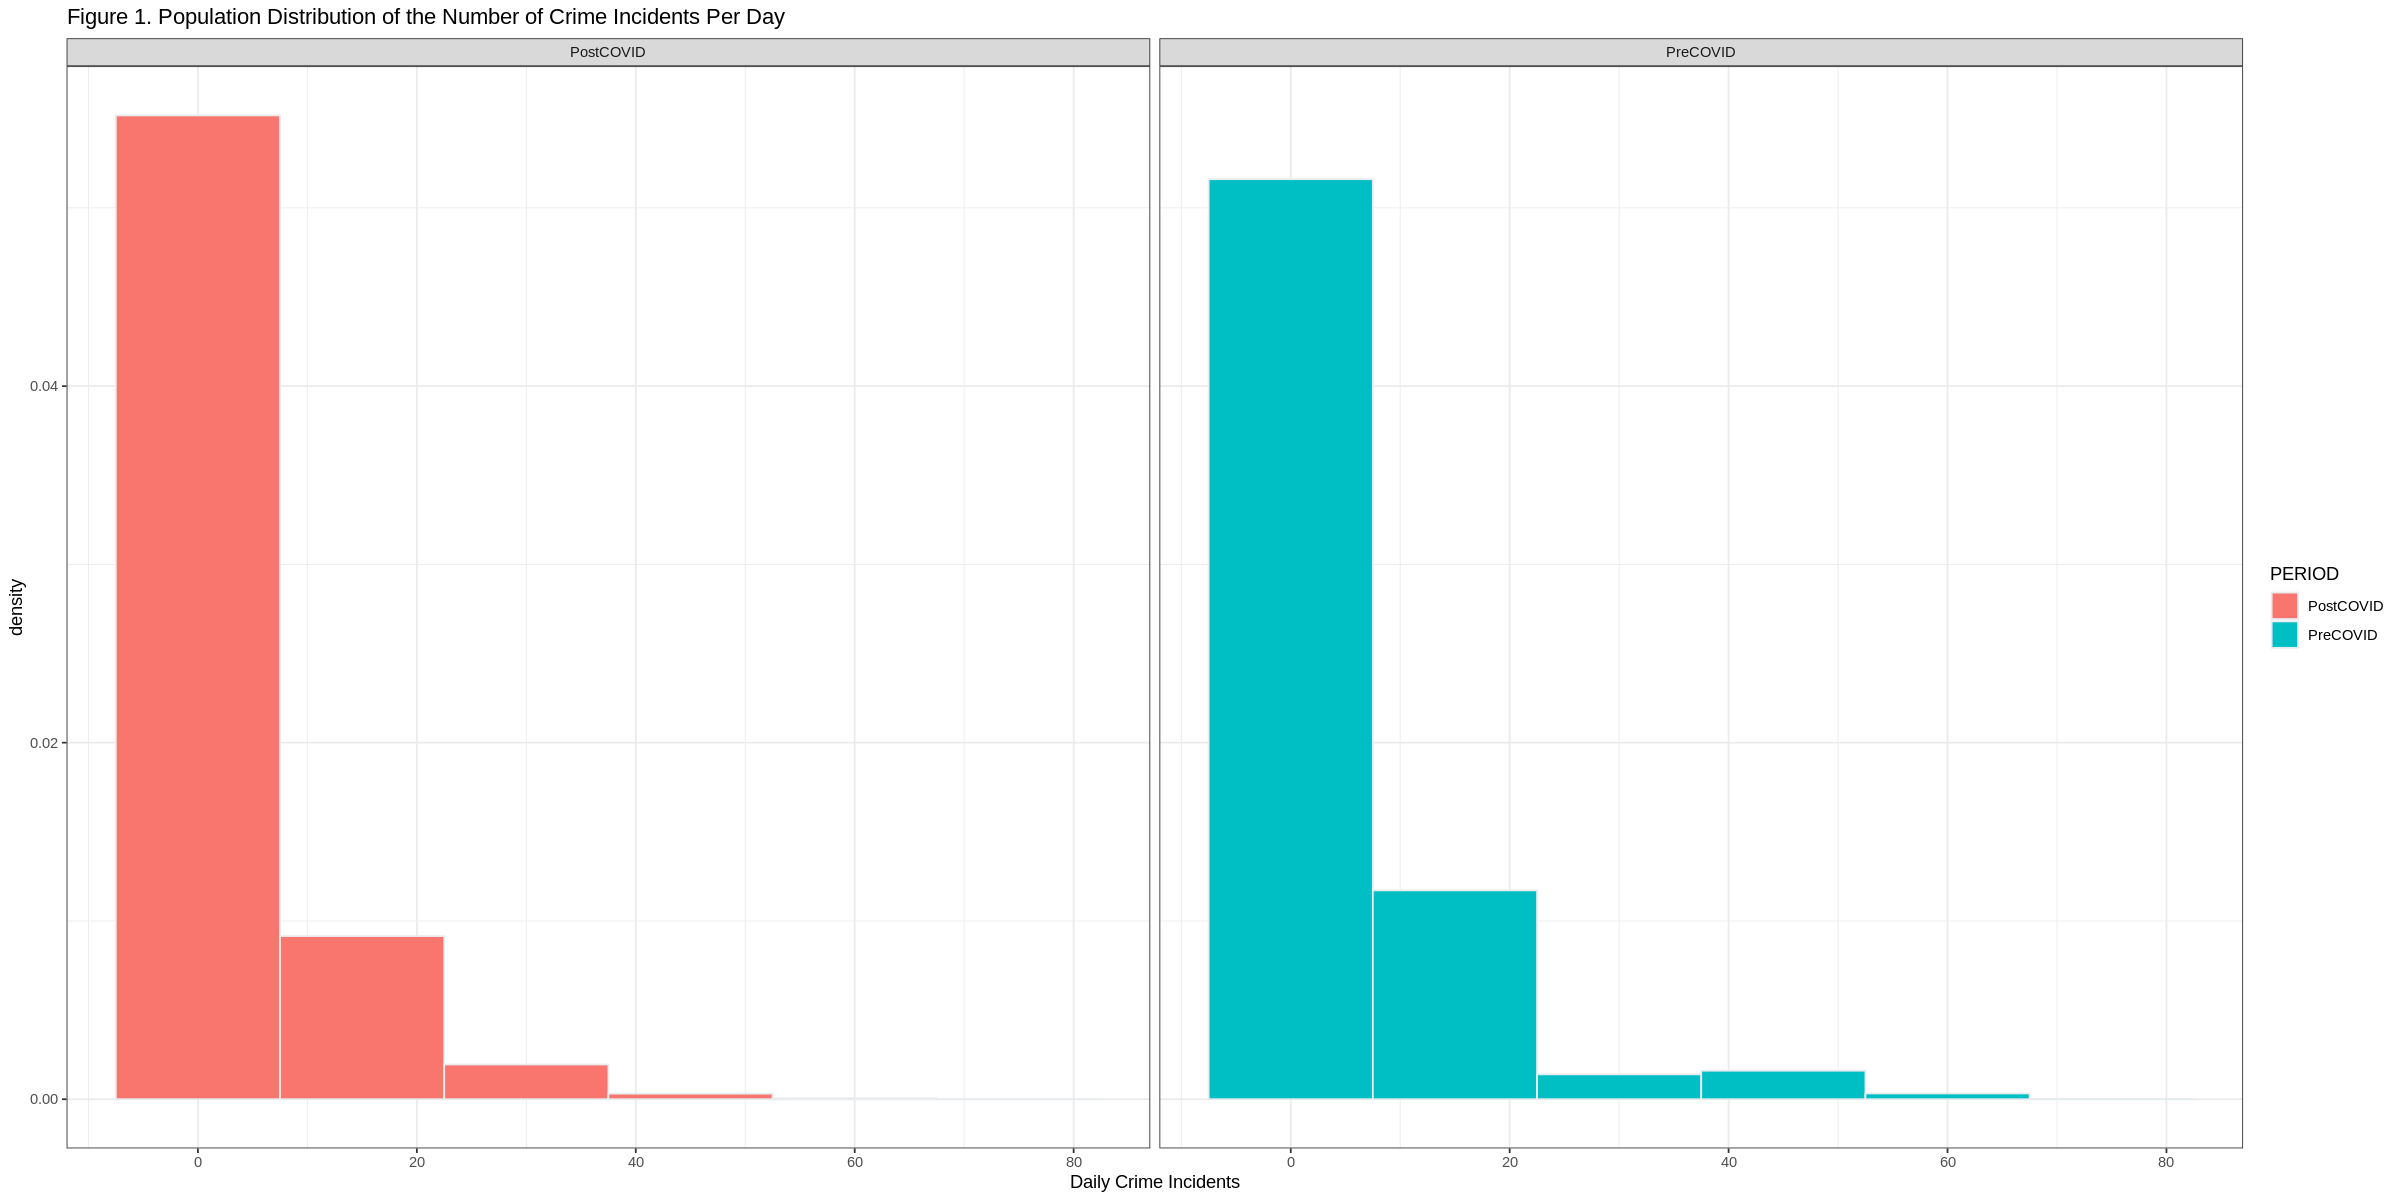

In [7]:
# visualization : population distribution
options(repr.plot.width = 20, repr.plot.height = 10)
pop_dist <- crime_total %>%
    ggplot(aes(x = total, y = ..density.., fill = PERIOD)) + 
    geom_histogram(binwidth = 15, color="#e9ecef") +
    theme(text = element_text(size = 15))+
    xlab("Daily Crime Incidents") +
    ggtitle("Figure 1. Population Distribution of the Number of Crime Incidents Per Day")+
    facet_wrap(~PERIOD)+
    theme_bw()
pop_dist

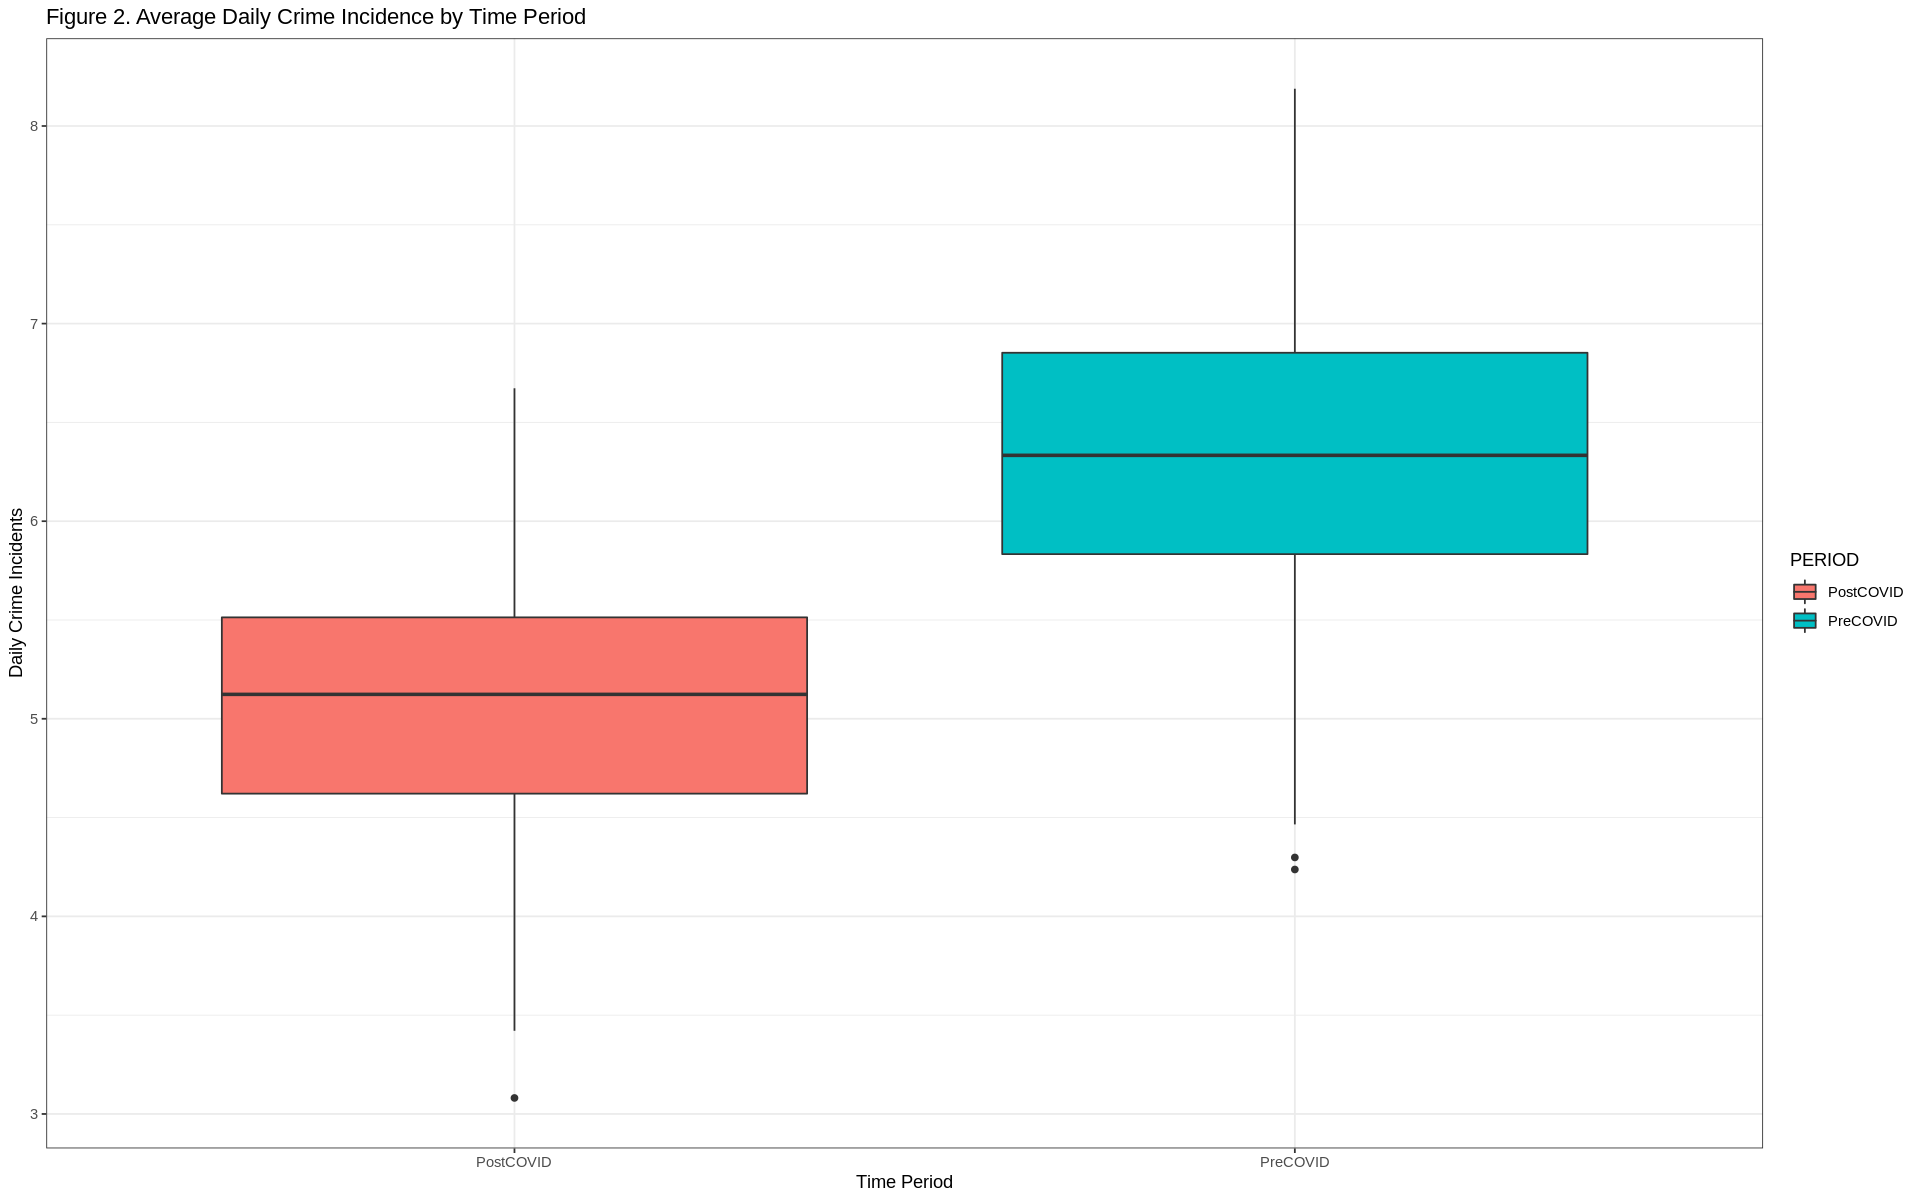

In [8]:
# visualization : visualizing the distribution of daily crime incidents for Post-COVID and Pre-COVID
options(repr.plot.width = 16, repr.plot.height = 10)
side_by_side_boxplot <- crime_daily_avg %>%
    ggplot(aes(x = PERIOD, y = daily_avg, fill = PERIOD)) +
    geom_boxplot() +
    theme(text = element_text(size = 15))+
    xlab("Time Period") +
    ylab("Daily Crime Incidents")+
    ggtitle('Figure 2. Average Daily Crime Incidence by Time Period') +
    theme_bw()

side_by_side_boxplot

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)
bootstrap_500 <- boot_500 %>% 
    ggplot() + 
    geom_histogram(aes(x = sample_mean, y = ..density..), binwidth = 2, color="white") +
    theme(text = element_text(size = 15))+
    xlab("Bootstrap Mean") +
    ggtitle("Bootstrapping of the sample mean for samples of size 500 for Crime in Vancouver from 2017-2022.") + 
    geom_line(data = data_normal, aes(total, density), color = "blue", lwd = 2)+
    coord_cartesian(xlim=c(0,40))
bootstrap_500

After analyzing the average number of crime incidents(crime rate) across time period. There exists a noticeable difference in crime rate between Pre-COVID and Post-COVID years. Specifically, a decrease in crime rate since the beginning of COVID-19 in 2020 was noted as depicted in the Figure 2. But such findings are rudimentary and speculative in nature, we need more robust evidence to confidently conclude the observed difference in crime rate is meaningful. In order to make the project results trustworthy, we decided to carry out the following: 

1. A paired sample t-test to test the average difference of daily crime incidents between year intervals 2017-2019 and 2020-2022; 
 <br> $H_0$ : $\mu_{2017-2019}$ - $\mu_{2020-2022}$ = 0;
 <br> $H_1$ : $\mu_{2017-2019}$ - $\mu_{2020-2022}$ > 0;
2. Generate a confidence interval from bootstrapping and CLT for the average difference in crime incidents between 2017-2019 and 2020-2022;
3. Compare the result obtained from bootstrapping and CLT.

### Result

#### Hypothesis Testing

In [9]:
# Perform a one-tailed paired sample t-test with alpha level of 0.05
paired_sample_t_test <- 
    na.omit(one_sample_wider) %>%  
    mutate(d = PreCOVID - PostCOVID) %>% 
    summarise(n = n(), 
               d_bar = mean(d), 
               sd =sd(d),
               std_error = sd/sqrt(n)) %>%
    mutate(p_value = pt(q = d_bar/std_error, # one_tailed test
                            df = n-1, 
                            lower.tail = FALSE))
# extract the p-value of the test
p_value <- pull(paired_sample_t_test[,6])
p_value

[1] 1.113717e-10

#### Confidence Interval From CLT

In [10]:
# 95% CI for the mean difference between Pre-Covid and Covid years.
CLT_95CI <- paired_sample_t_test %>%  
    summarize(lower_ci = d_bar - qnorm(0.975)* std_error,
              upper_ci = d_bar + qnorm(0.975)* std_error)
CLT_95CI

lower_ci,upper_ci
<dbl>,<dbl>
0.7527404,1.184918


**Interpretation**:\
From the CLT confidence interval, we are 95% confident the true mean difference in crime rate between pre-covid and during-covid will fall between [0.7527404, 1.184918].

#### Confidence Interval From Bootstrapping

In [11]:
# 95% Confidence Interval From Bootstrap Distribution
set.seed(32)

# take the difference between daily_avg
sample <- 
    na.omit(one_sample_wider) %>%  
    mutate(d = PreCOVID - PostCOVID) %>%
    select(d)

# generate 1000 bootstrap samples
boots_samples <- sample %>%
    rep_sample_n(size = 36, reps = 1000, replace = TRUE) %>%
    group_by(replicate)%>%
    summarise(sample_mean = mean(d), `.groups` = "drop")

# obtain 95% CI from the bootstrap distribution
bootstrap_95CI <- boots_samples %>%
    get_confidence_interval(level = 0.95, type = "percentile")
bootstrap_95CI

Adding missing grouping variables: `replicate`



lower_ci,upper_ci
<dbl>,<dbl>
0.7734388,1.196619


**Interpretation**:\
From the Bootstrapping confidence interval, we are 95% confident the true mean difference in crime rate between pre-covid and during-covid will fall between [0.7734388, 1.196619].

#### Compare the Results from CLT and Bootstrapping Methods

The method of asymptotics, namely the central limit theorem (CLT), relies on the assumptions that the underlying population distribution is normal or the sample size is sufficiently large, the sample is drawn independently, and the estimator is composed of random components. The use of CLT is only valid under such conditions. In the current analysis, the use of CLT is warranted as the current sample size (n = 36) is above the commonly accepted threshold (n >= 30) despite the fact that the underlying distribution of the variable daily crime incidence is severely positively skewed (see Figure 1.). One caveat to note, the confidence interval for the average daily crime incidence generated from CLT is an underestimate of the true uncertainty around our estimator. Indeed, as we can see from above the 95%CI obtained from CLT is narrower than the 95%CI obtained from bootstrapping distribution. This is due to the fact that we used sample variance to approximate the population level variance.

On the other hand, the method of bootstrapping is free from the aforementioned conditions in constructing a confidence interval. However, the bootstrapping method relies on the assumption that the original sample taken from the population is representative, otherwise the centre of the bootstrap distribution could be very different from that of the true sampling distribution. 

In the current analysis, the use of asymptotics and bootstrapping are both valid and there only exist small differences between the two confidence intervals. However, in the context of our analysis, the bootstrapping method is more appropriate mainly for the reason that the population distribution is severely skewed and we are using a sample size of 36 which is just above the theoretical threshold(n >= 30). For this reason, we think the confidence interval obtained from CLT might discount too much of the variability therefore bootstrapping would be a better method.


## Discussion

In this project, we are interested in the change in the daily crime incidents (or crime rate for short) between pre-Covid (2017-2019) and post-Covid (2020-2022) periods in Vancouver. As shown in Figure 1, we first visualized the population distribution for and found that the distribution is fairly skewed. Since the population distribution is not normal, we would need a large sample size to warrant the use of CLT in constructing the confidence interval. For this reason we need a sample size of at least 30. To test if the observed difference between the above two periods is significant, we conducted a paired-sample t-test to test our hypothesis and generate two 95% confidence intervals, one using bootstrap and the other using CLT.  

From the hypothesis test, we obtained a extremely small p-value = 1.11371744028295e-10, which indicates that the likelihood of found another mean difference in crime rate between the two time periods that is at least as extreme as the one found in our analysis is extremely unlikely if the null model is true. In other words, the average difference in crime rate between pre-covid and during-covid is highly unlikely to equal zero. Therefore, we can conclude from our analysis that the crime rate of pre-covid period is significantly higher than that of post-covid period. This result is expected as we have observed such a difference in the population distribution. 

We then constructed two 95% confidence intervals for the observed statistic. From `CLT_95CI` and `bootstrap_95CI` we can see that both of these intervals do not include 0 (H0 value), so this also provides strong evidence that the null model is unlikely to hold therefore should be rejected. We can also conclude that pre-covid period has a higher daily crime rate than the post-covid time. 
We think these results provided robust evidence on a change in crime rate in Vancouver following the Covid-19 pandemic. 

We noted that there are frequent lockdowns carried out during the covid time across districts of Vancouver, which might explain part of the reason for the decrease in the crime rate in Vancouver following Covid-19. Nevertheless, we think such results could be informative for policy makers if this change in crime rate is later found to be long lasting. Furthermore, such results could lead to interesting follow up questions such as does the observed long term change in trend in criminal activity related to periods of economic downturn, if so would a reversal in trend be an indicator of economic recovery? 

## Reference
- Abrams, D. S. (2021). COVID and crime: An early empirical look. Journal of Public Economics, Volume 194(2021), 104344. ScienceDirect. https://doi.org/10.1016/j.jpubeco.2020.104344 

- Ashby, M. P. J. (2020). Initial evidence on the relationship between the coronavirus pandemic and crime in the United States. Crime Science, 9(2020), 6. https://doi.org/10.1186/s40163-020-00117-6 

- Vancouver Police Department. (2022, February 15). GeoDASH Crime Data. Vancouver Police Department - GeoDASH. Retrieved March 5, 2022, from https://vpd.ca/crime-statistics/
